In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils


from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


import string
alphabet = list(string.ascii_lowercase)
          

## Data

Data for this is from https://gmd.copernicus.org/articles/11/1133/2018/ CDRMIP data, where pi-CO2pulse is the 100GtC pulse and piControl is the control

In [2]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['__xarray_dataarray_variable__']
G_cdr_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']

In [7]:
#rolling 5 year mean 
G_ds = G_ds.rolling(year = 5, min_periods = 1, center = False).mean('year')
G_cdr_ds = G_cdr_ds.rolling(year = 5, min_periods = 1, center = False).mean('year')

In [8]:
A = utils.A

In [9]:
model_color = utils.model_color

## Global Mean plots

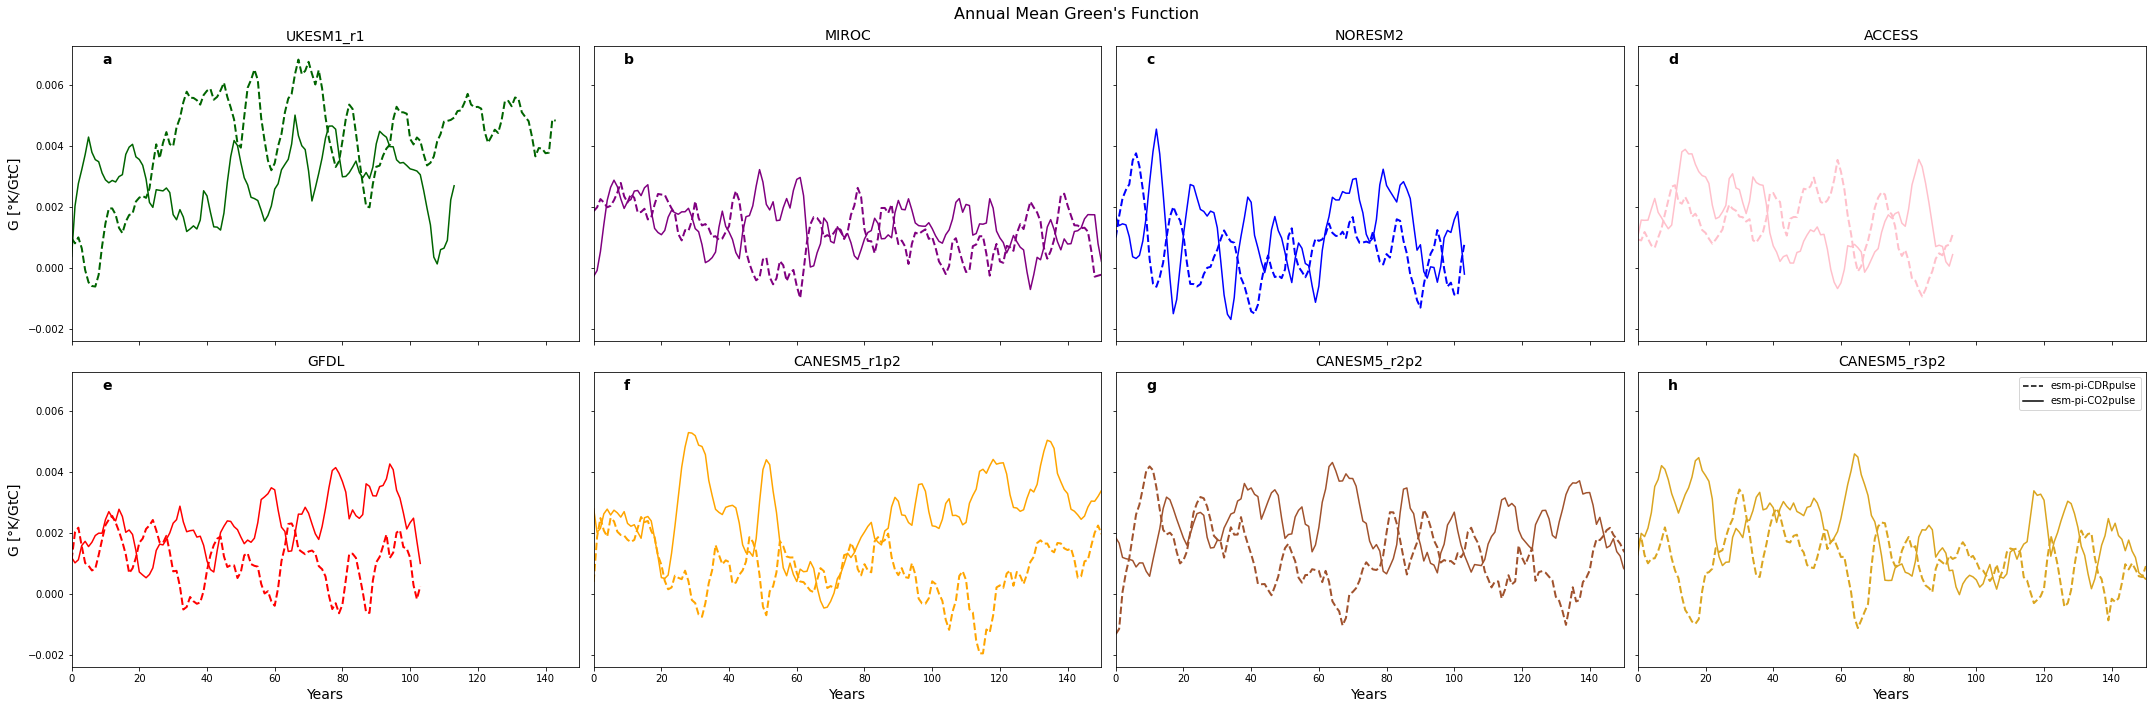

In [10]:
fig, axes = plt.subplots(2,4,figsize = [30,10], sharey = True, sharex = True)
alpha_labels = iter(alphabet)

plt.suptitle('Annual Mean Green\'s Function', fontsize = 16)
for ax, m in zip(axes.ravel(), G_ds.model.values):
    G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(ax = ax, color = model_color[m])
    (-G_cdr_ds).weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(ax = ax, color = model_color[m], linestyle = '--', linewidth = 2)
    ax.set_xlim(G_ds.year.min(), G_ds.year[150].values)
    ax.set_title(m, fontsize = 14)
    
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    label = next(alpha_labels)
    ax.text(x = .06, y =.94, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
  
    
axes[0,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
axes[1,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
for idx in [0,1,2,3]:
    axes[1,idx].set_xlabel('Years', fontsize = 14)


####### legend ##########
 
cdr = Line2D([0], [0], linestyle = '--', label='esm-pi-CDRpulse', color='black')
co2 = Line2D([0], [0], label='esm-pi-CO2pulse', color='black')
handles = [cdr, co2]
plt.legend(handles=handles)

plt.tight_layout()
plt.savefig('figures/paper/GF_mean_all_models.png', bbox_inches = 'tight', dpi = 300)

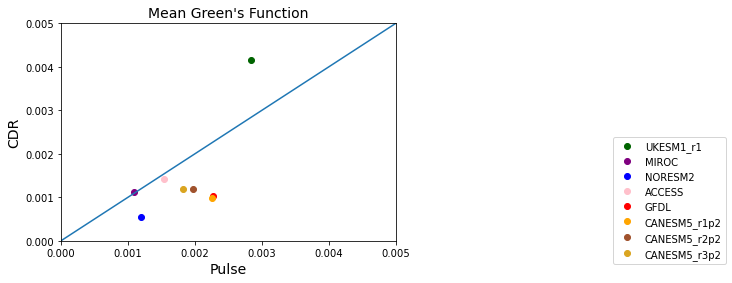

In [11]:
for m in G_ds.model.values:
    plt.plot(G_ds.weighted(A).mean(dim = ['year','lat','lon']).sel(model = m), -
             G_cdr_ds.weighted(A).mean(dim = ['year','lat','lon']).sel(model = m), 
             'o', color = utils.model_color[m], label = m)
plt.plot(np.arange(0,0.006,0.0001),np.arange(0,0.006,0.0001))
plt.legend(bbox_to_anchor=(2.0,0.5))
plt.xlim(0,0.005)
plt.xlabel('Pulse', fontsize = 14)
plt.ylim(0,0.005)
plt.ylabel('CDR', fontsize = 14)
plt.title('Mean Green\'s Function', fontsize = 14)
plt.savefig('figures/GF_dev/comparison_mean.png', bbox_inches = 'tight', dpi = 300)

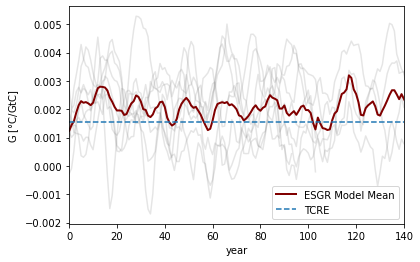

In [12]:
for m in G_ds.model:
    G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(alpha = .2, color = 'grey')
plt.title('Annual Mean', fontsize = 16)
plt.xlim(G_ds.year.min(), G_ds.year[140].values)

G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'model').plot(label = 'ESGR Model Mean', color = 'maroon', linewidth = 2)
plt.axhline(0.00155475, linestyle = '--', label = 'TCRE')
plt.ylabel('G [$\degree$C/GtC]')
plt.legend()
plt.savefig('figures/GF_dev/all_models_monthly.png', bbox_inches = 'tight', dpi = 350)


## Spatial Plots

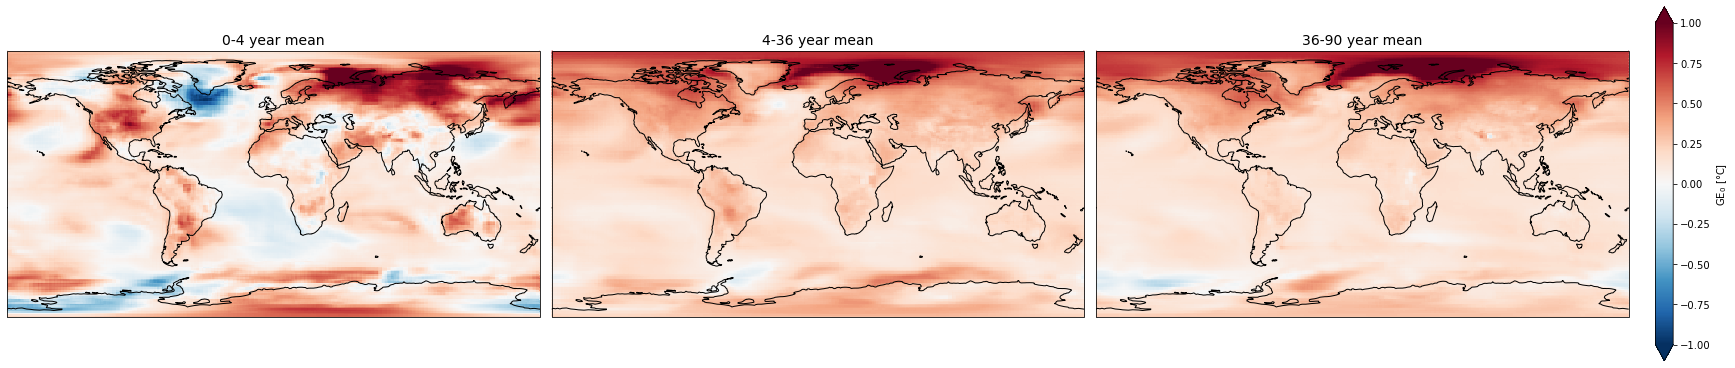

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = [24,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout=True)
(G_ds.mean(dim = ['model'])*100).isel(year = slice(0,4)).mean(dim = 'year').plot(ax = ax0, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r', add_colorbar = False)
ax0.set_title('0-4 year mean', fontsize = 14)
ax0.coastlines()
(G_ds.mean(dim = ['model'])*100).isel(year = slice(4,36)).mean(dim = 'year').plot(ax = ax1, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r', add_colorbar = False)
ax1.set_title('4-36 year mean', fontsize = 14)
ax1.coastlines()

(G_ds.mean(dim = ['model'])*100).isel(year = slice(36,90)).mean(dim = 'year').plot(ax = ax2, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax2.set_title('36-90 year mean', fontsize = 14)
ax2.coastlines()


plt.savefig('figures/paper/GF_time_varying_long.png', bbox_inches = 'tight', dpi = 350)

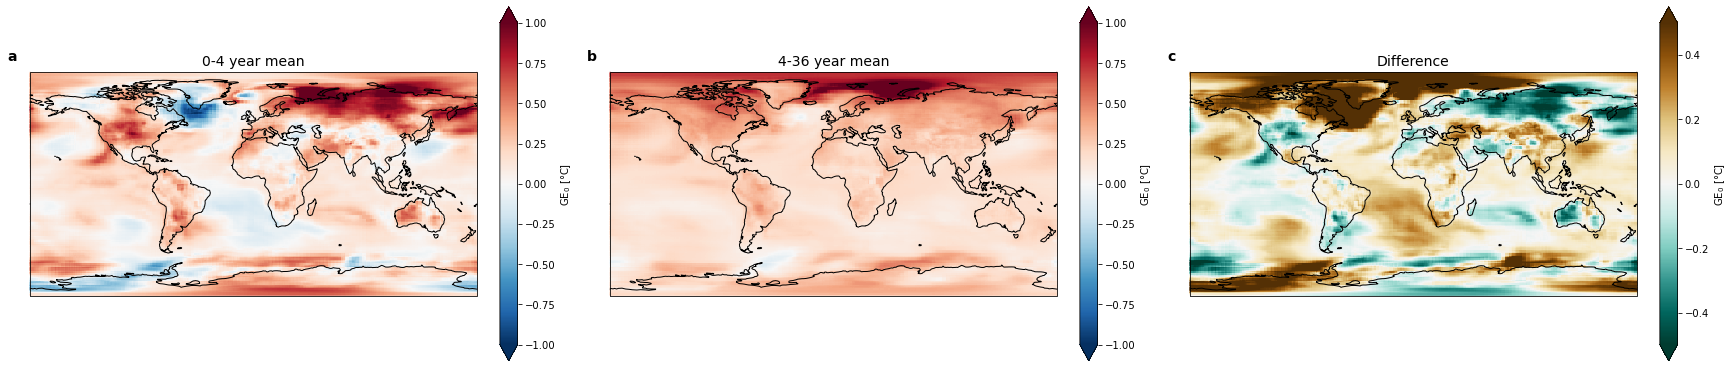

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = [24,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout=True)
alpha_labels = iter(alphabet)

(G_ds.mean(dim = ['model'])*100).isel(year = slice(0,4)).mean(dim = 'year').plot(ax = ax0, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax0.set_title('0-4 year mean', fontsize = 14)
ax0.coastlines()
(G_ds.mean(dim = ['model'])*100).isel(year = slice(4,36)).mean(dim = 'year').plot(ax = ax1, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax1.set_title('4-36 year mean', fontsize = 14)
ax1.coastlines()

((G_ds.mean(dim = ['model'])*100).isel(year = slice(4,36)).mean(dim = 'year') - 
 (G_ds.mean(dim = ['model'])*100).isel(year = slice(0,4)).mean(dim = 'year')).plot(ax = ax2, vmax = 0.5, vmin = -0.5, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'BrBG_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax2.set_title('Difference', fontsize = 14)
ax2.coastlines()

for ax in [ax0,ax1,ax2]:
    label = next(alpha_labels)
    ax.text(x = -0.05, y =1.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

plt.savefig('figures/paper/GF_time_varying.png', bbox_inches = 'tight', dpi = 350)